### Data unification

In [1]:
import pandas as pd
import os
import statsmodels.stats.multitest as multi
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
#load in SNP lists from each step of analysis into a unified table
#starting point
all_snp_table=pd.read_csv("../tables/time-germline.csv",sep="\t")
risk_snps_melanoma=pd.read_csv("../data/risk_model/melanoma_final_snps.txt",sep="\t")
risk_snps_melanoma=risk_snps_melanoma["0"]
risk_snps_prostate=pd.read_csv("../data/risk_model/prostate_final_snps.txt",sep="\t")
risk_snps_prostate=risk_snps_prostate["0"]

OS_snps=pd.read_csv("../data/survival/OS_input_snps.txt",sep="\t")
OS_snps["snps"]=OS_snps["snps"].str.rsplit("_").str[0]
OS_snps_short=OS_snps["snps"].drop_duplicates()
OS_snps_short=OS_snps_short.tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in OS_snps_short.tolist()]

PFS_snps=pd.read_csv("../data/survival/PFS_input_snps.txt",sep="\t")
PFS_snps["snps"]=PFS_snps["snps"].str.rsplit("_").str[0]
PFS_snps_short=PFS_snps["snps"].drop_duplicates()
PFS_snps_short=PFS_snps_short.tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in PFS_snps_short.tolist()]

OS_PFS_snps_short=pd.DataFrame(OS_snps_short+PFS_snps_short)

icb_snps=pd.read_csv("../data/icb-prs/icb_final_snps.txt",sep="\t",header=None)
icb_snps=icb_snps[1]
icb_snps=icb_snps.str.rsplit("_").str[0]
icb_snps=icb_snps.tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in icb_snps.tolist()]

all_snp_table["risk_melanoma"]=np.where(all_snp_table["snp_noallele"].isin(risk_snps_melanoma),"yes","no")
all_snp_table["risk_prostate"]=np.where(all_snp_table["snp_noallele"].isin(risk_snps_prostate),"yes","no")
all_snp_table["risk_either"]=np.where(all_snp_table["snp_noallele"].isin(risk_snps_prostate.tolist()+risk_snps_melanoma.tolist()),"yes","no")

all_snp_table["OS"]=np.where(all_snp_table["snps"].isin(OS_snps_short),"yes","no")
all_snp_table["PFS"]=np.where(all_snp_table["snps"].isin(PFS_snps_short),"yes","no")
all_snp_table["OS_PFS"]=np.where(all_snp_table["snps"].isin(OS_PFS_snps_short[0].tolist()),"yes","no")
all_snp_table["icb_filt"]=np.where(all_snp_table["snps"].isin(icb_snps),"yes","no")


In [4]:
for cancer in OS_snps["cancer"].unique():
    OS_snps_temp=OS_snps[OS_snps["cancer"]==cancer]
    OS_snps_temp=OS_snps_temp["snps"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in OS_snps_temp["snps"].tolist()]
    all_snp_table["OS_"+cancer]=np.where(all_snp_table["snps"].isin(OS_snps_temp),"yes","no")
    
for cancer in PFS_snps["cancer"].unique():
    PFS_snps_temp=PFS_snps[PFS_snps["cancer"]==cancer]
    PFS_snps_temp=PFS_snps_temp["snps"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in PFS_snps_temp["snps"].tolist()]
    all_snp_table["PFS_"+cancer]=np.where(all_snp_table["snps"].isin(PFS_snps_temp),"yes","no") 

In [67]:
#Read in DICE+ieqtl information
dice_ieqtl=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/fig3/LASSO_fdr0.05_Supplemental_Table_10.csv",sep=",")
dice_ieqtl=dice_ieqtl.dropna()

dice_ieqtl_wide=pd.DataFrame()

for snp in dice_ieqtl["snp"]:
    
    cells=dice_ieqtl.loc[np.logical_and(dice_ieqtl["snp"]==snp,dice_ieqtl["type"]=="ieqtl"),"cell"]
    cells=", ".join(cells)
    dice_ieqtl_wide.loc[snp,"ieqtl"]=cells
    
    cells=dice_ieqtl.loc[np.logical_and(dice_ieqtl["snp"]==snp,dice_ieqtl["type"]=="dice"),"cell"]
    cells=", ".join(cells)
    dice_ieqtl_wide.loc[snp,"dice"]=cells

dice_ieqtl_wide["rsid"]=dice_ieqtl_wide.index

all_snp_table=pd.merge(all_snp_table,dice_ieqtl_wide,on="rsid",how="left")

In [68]:
#incorporate VEP information in, as well as venn diagram style overlaps of key characteristics

In [69]:
#read in VEP
vep_variant=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/1wRJKFf4lMtcef6e.txt",sep="\t")

In [70]:
missense_snps=vep_variant[(vep_variant["Consequence"].str.contains("missense"))]["#Uploaded_variation"].unique().tolist()
TF_snps=vep_variant[vep_variant["Consequence"].str.contains("TF")]["#Uploaded_variation"].unique().tolist()
NMD=vep_variant[vep_variant["Consequence"].str.contains("NMD")]["#Uploaded_variation"].unique().tolist()
noncoding=[x for x in set(vep_variant[vep_variant["Consequence"].str.contains("non_coding")]["#Uploaded_variation"].unique().tolist()+vep_variant[vep_variant["Consequence"].str.contains("prime")]["#Uploaded_variation"].unique().tolist()+vep_variant[vep_variant["Consequence"].str.contains("regulatory")]["#Uploaded_variation"].unique().tolist()+vep_variant[vep_variant["Consequence"].str.contains("intergenic")]["#Uploaded_variation"].unique().tolist()+vep_variant[vep_variant["Consequence"].str.contains("intron")]["#Uploaded_variation"].unique().tolist()+vep_variant[vep_variant["Consequence"].str.contains("stream")]["#Uploaded_variation"].unique().tolist())]
splice=vep_variant[vep_variant["Consequence"].str.contains("splice")]["#Uploaded_variation"].unique().tolist()

In [71]:
TF_snps=[x for x in TF_snps if x not in missense_snps]
NMD=[x for x in NMD if x not in missense_snps]
noncoding=[x for x in noncoding if x not in missense_snps+TF_snps+NMD+splice]
splice=[x for x in splice if x not in missense_snps]

TF_snps=TF_snps+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in TF_snps]
NMD=NMD+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in NMD]
noncoding=noncoding+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in noncoding]
splice=splice+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in splice]
missense_snps=missense_snps+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in missense_snps]

all_snp_table["VEP_TranscriptionFactor"]=np.where(all_snp_table["snps"].isin(TF_snps),"yes","no")
all_snp_table["VEP_NMD"]=np.where(all_snp_table["snps"].isin(NMD),"yes","no")
all_snp_table["VEP_noncoding"]=np.where(all_snp_table["snps"].isin(noncoding),"yes","no")
all_snp_table["VEP_splice"]=np.where(all_snp_table["snps"].isin(splice),"yes","no")
all_snp_table["VEP_missense"]=np.where(all_snp_table["snps"].isin(missense_snps),"yes","no")

## VEP plot

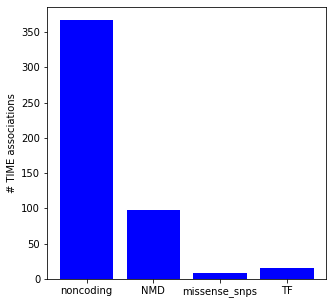

In [72]:
#quick VEP plot

all_snp_table_LASSO_PASS=all_snp_table.loc[np.logical_or(np.logical_or(all_snp_table["OS_PFS"]=="yes",all_snp_table["icb_filt"]=="yes"),all_snp_table["risk_either"]=="yes"),:]
all_snp_table_LASSO_PASS=all_snp_table_LASSO_PASS.drop_duplicates(subset="rsid")

noncoding_num=all_snp_table_LASSO_PASS["VEP_noncoding"].value_counts()[0]
NMD_num=all_snp_table_LASSO_PASS["VEP_NMD"].value_counts()[1]
missense_snps_num=all_snp_table_LASSO_PASS["VEP_missense"].value_counts()[1]
TF_num=all_snp_table_LASSO_PASS["VEP_TranscriptionFactor"].value_counts()[1]

fig = plt.figure(figsize=(5,5))
plt.bar(["noncoding", "NMD","missense_snps", "TF"],[noncoding_num, NMD_num, missense_snps_num, TF_num],color="blue")
plt.ylabel("# TIME associations")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig4/LASSO_vep.pdf")

In [61]:
#all_snp_table_LASSO_PASS[all_snp_table_LASSO_PASS["VEP_missense"]=="yes"].to_csv("/cellar/users/tsears/projects/germline-immune/data/missense_only_vep_LASSO.txt",sep="\t",header=True)
missense_vars=all_snp_table_LASSO_PASS[all_snp_table_LASSO_PASS["VEP_missense"]=="yes"]
vep_variant[vep_variant["#Uploaded_variation"].isin(missense_vars["snps"].tolist())].to_csv("/cellar/users/tsears/projects/germline-immune/data/missense_only_vep_protein_info.txt",sep="\t",header=True)

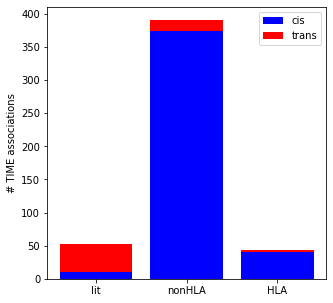

In [31]:
all_snp_table_LASSO_PASS=all_snp_table.loc[np.logical_or(np.logical_or(all_snp_table["OS_PFS"]=="yes",all_snp_table["icb_filt"]=="yes"),all_snp_table["risk_either"]=="yes"),:]
all_snp_table_LASSO_PASS=all_snp_table_LASSO_PASS.drop_duplicates(subset="rsid")

lit=all_snp_table_LASSO_PASS[all_snp_table_LASSO_PASS["maf"].isnull()]
num_lit_cis=len(lit[lit["file"].isin(["CTLA4","PD.L1","CTSW","APOE","PDCD1"])])
num_lit_trans=len(lit[~lit["file"].isin(["CTLA4","PD.L1","CTSW","APOE","PDCD1"])])

non_lit=all_snp_table_LASSO_PASS[~all_snp_table_LASSO_PASS["maf"].isnull()]

hla=non_lit[~non_lit["type"].isnull()]
num_hla_cis=len(hla[~hla["cis tss"].isnull()])
num_hla_trans=len(hla[hla["cis tss"].isnull()])

nonhla=non_lit[non_lit["type"].isnull()]
num_nonhla_cis=len(nonhla[~nonhla["cis tss"].isnull()])
num_nonhla_trans=len(nonhla[nonhla["cis tss"].isnull()])

fig = plt.figure(figsize=(5,5))
p1 = plt.bar(["lit","nonHLA","HLA"], [num_lit_cis,num_nonhla_cis,num_hla_cis],  color='blue', label="cis")
p2 = plt.bar(["lit","nonHLA","HLA"], [num_lit_trans,num_nonhla_trans,num_hla_trans], bottom=[num_lit_cis,num_nonhla_cis,num_hla_cis], color='r',label="trans")
plt.ylabel("# TIME associations")
plt.legend()
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig7/LASSO_cis.trans.pdf")

In [35]:
num_lit_cis+num_nonhla_cis+num_hla_cis,num_lit_trans+num_nonhla_trans+num_hla_trans

(424, 63)

In [526]:
#export all LASSO rsids
pd.DataFrame(all_snp_table.loc[np.logical_or(np.logical_or(all_snp_table["OS_PFS"]=="yes",all_snp_table["icb_filt"]=="yes"),all_snp_table["risk_either"]=="yes"),"rsid"].unique()).to_csv("/cellar/users/tsears/projects/germline-immune/data/fig3/LASSO_snp_list_rsid.txt",sep="\t",index=False,header=False)

#export all LASSO snps (reverse too?)
all_lasso_snps=all_snp_table.loc[np.logical_or(np.logical_or(all_snp_table["OS_PFS"]=="yes",all_snp_table["icb_filt"]=="yes"),all_snp_table["risk_either"]=="yes"),"snps"].unique()
all_lasso_snps=all_lasso_snps.tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in all_lasso_snps.tolist()]
pd.DataFrame(all_lasso_snps).to_csv("/cellar/users/tsears/projects/germline-immune/data/fig3/LASSO_snp_list_fwd_rev.txt",sep="\t",index=False,header=False)

In [539]:
#Export common to all analysis SNPs
shared_lasso_snps=all_snp_table.loc[np.logical_and(np.logical_and(all_snp_table["OS_PFS"]=="yes",all_snp_table["icb_filt"]=="yes"),all_snp_table["risk_either"]=="yes"),"snps"].unique()
shared_lasso_snps=shared_lasso_snps.tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in shared_lasso_snps.tolist()]
pd.DataFrame(shared_lasso_snps).to_csv("/cellar/users/tsears/projects/germline-immune/data/shared_LASSO_fwd_rev.txt",sep="\t",index=False,header=False)

### LASSO Fig 3. 

In [492]:
num_icb=len(all_snp_table.loc[all_snp_table["icb_filt"]=="yes","file"].unique())
num_risk=len(all_snp_table.loc[all_snp_table["risk_either"]=="yes","file"].unique())
num_survival=len(all_snp_table.loc[all_snp_table["OS_PFS"]=="yes","file"].unique())

No handles with labels found to put in legend.


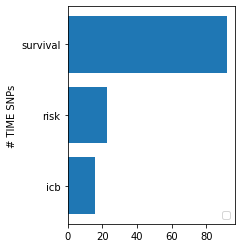

In [493]:
plt.figure(figsize=(3,4))
plt.barh(["icb","risk","survival"],[num_icb,num_risk,num_survival])
plt.ylabel("# TIME SNPs")
plt.legend()
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig3/genes_cancer.snps.barv_LASSO_IP.pdf",bbox_inches='tight')

In [494]:
#map snps to category
pheno=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_1.csv",header=None)
pheno[3]=pheno[3].fillna(pheno[2])

networkx=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/networkx/networkx.group.csv")
mp_networkx=dict(zip(networkx["nodes"],networkx["group"]))

pheno[3]=pheno[1].map(mp_networkx).fillna(pheno[3])
mp_category=dict(zip(pheno[1],pheno[3]))

all_snp_table["category"]=all_snp_table["file"].map(mp_category).fillna(all_snp_table["file"])

mp_category_clean={
    "Module3_IFN_score":"IFN",
    "TGFB_score_21050467":"TGFbeta",
    "HLA-H":"MHC-I",
    "HLA-DQA2":"MHC-II",
    "HLA-G":"MHC-I",
    "HLA-DQA1":"MHC-II",
    "HLA-A":"MHC-I",
    "HLA-DQB2":"MHC-II",
    "HLA-F":"MHC-I",
    "HLA-B":"MHC-I",
    "HLA-DQB1":"MHC-II",
    "HLA-DRB5":"MHC-II",
    "HLA-DRB1":"MHC-II",
    "HLA-C":"MHC-I",
    "HLA-DPB1":"MHC-I",
    "NKT":"NK",
    "cDC":"DC",
    "iDC":"DC",
    "Class-switched_memory_B-cells":"B cells",
    "Memory_B-cells":"B cells",
    "pDC":"DC",
    "NK_cells":"NK",
    "Sigs160-Bindea_aDC":"DC",
    "Sigs160-Bindea_Tfh-cells":"Tfh",
    "Sigs160-Wolf_Interferon-Cluster-21214954":"IFN",
    "Sigs160-Bindea_Th17-cells":"Th17",
    "Sigs160-Wolf_Interferon-19272155":"IFN",
    "Sigs160-Wolf_IFN-21978456":"IFN",
    "Sigs160-Wolf_Module3-IFN-score":"IFN",
    "Core56-Cell-Proportion_Eosinophils_Binary-MedianLowHigh":"Eosinophils",
    "PD-L1":"immune checkpoint",
    "APOE":"APOE",
    "Sigs160-Bindea_Cytotoxic-cells":"Cytotoxic Cells",
    "Macrophages":"Monocytes"
}

all_snp_table["category"]=np.where(all_snp_table["category"]=="immune infiltration",all_snp_table["file"],all_snp_table["category"])
all_snp_table["category"]=np.where(all_snp_table["category"]=="CSF1_response","APOE",all_snp_table["category"])
all_snp_table["category_clean"]=all_snp_table["category"].map(mp_category_clean).fillna(all_snp_table["category"])

In [505]:
sig_snps_results_surv=all_snp_table[all_snp_table["OS_PFS"]=="yes"]
sig_snps_results_icb=all_snp_table[all_snp_table["icb_filt"]=="yes"]
sig_snps_results_ukbb=all_snp_table[all_snp_table["risk_either"]=="yes"]

num_risk=sig_snps_results_ukbb.drop_duplicates(subset="file")
num_survival=sig_snps_results_surv.drop_duplicates(subset="file")
num_icb=sig_snps_results_icb.drop_duplicates(subset="file")

In [506]:
risk_df=num_risk[num_risk["risk_either"]!="no"][["risk_either","category_clean"]].groupby(["risk_either","category_clean"]).size().reset_index()
risk_df.columns=["cancer cat","pheno cat","values"]
risk_df["cancer cat"]=risk_df["cancer cat"].map({"yes":"risk"})

surv_df=num_survival[num_survival["OS_PFS"]!="no"][["OS_PFS","category_clean"]].groupby(["OS_PFS","category_clean"]).size().reset_index()
surv_df.columns=["cancer cat","pheno cat","values"]
surv_df["cancer cat"]=surv_df["cancer cat"].map({"yes":"survival"})

icb_df=num_icb[num_icb["icb_filt"]!="no"][["icb_filt","category_clean"]].groupby(["icb_filt","category_clean"]).size().reset_index()
icb_df.columns=["cancer cat","pheno cat","values"]
icb_df["cancer cat"]=icb_df["cancer cat"].map({"yes":"icb"})

cat_df=risk_df.append(surv_df)
cat_df=cat_df.append(icb_df)

In [507]:
cat_df=cat_df.pivot(columns="pheno cat",index="cancer cat",values="values")
cat_df=cat_df.fillna(0)

In [508]:
cat_df=cat_df.loc[["risk","survival","icb"]]

In [510]:
cat_df=cat_df[["group1","group2","MHC-I","MHC-II","Sigs160-Wolf_MHC2-21978456","immune checkpoint","DC","IFN","Th17","Tfh","Sigs160-Attractors_IFIT3","Th2_cells"]]

In [511]:
cat_df=cat_df.iloc[[1,0,2],:]

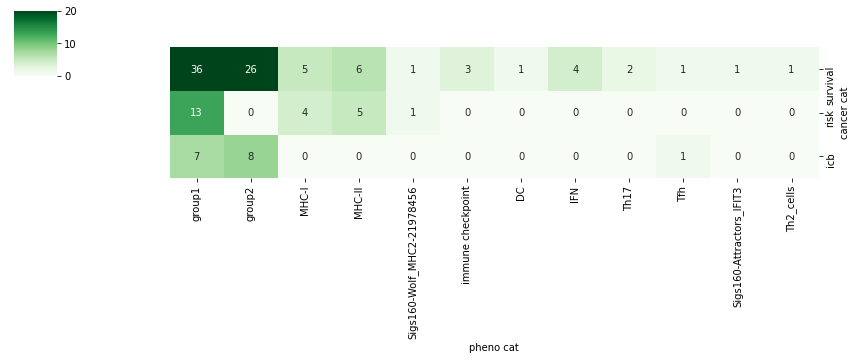

In [515]:
sns.clustermap(cat_df,cmap="Greens",figsize=(12,5),row_cluster=False,col_cluster=False,annot=True,vmax=20,fmt=".3g")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig3/LASSO_IP_cancer.snps.green.clustermap.pdf")

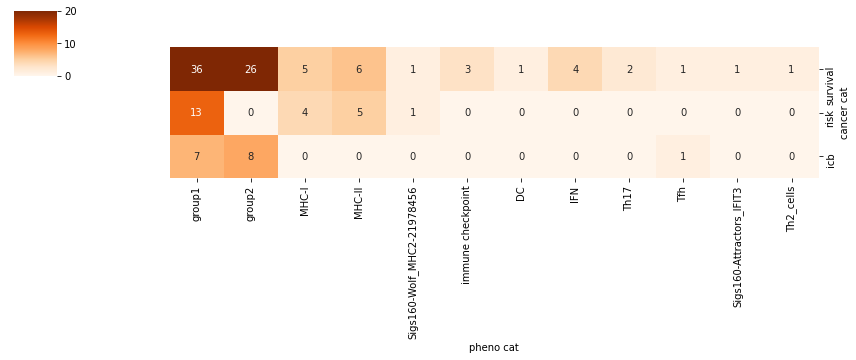

In [513]:
sns.clustermap(cat_df,cmap="Oranges",figsize=(12,5),row_cluster=False,col_cluster=False,annot=True,vmax=20,fmt=".3g")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig3/LASSO_IP_cancer.snps.orange.clustermap.pdf")

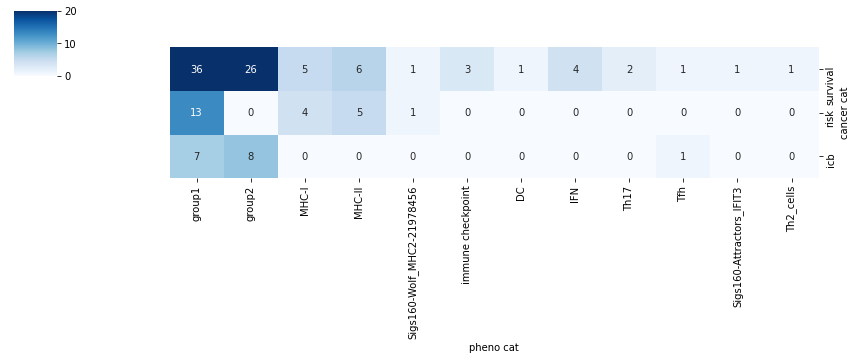

In [514]:
sns.clustermap(cat_df,cmap="Blues",figsize=(12,5),row_cluster=False,col_cluster=False,annot=True,vmax=20,fmt=".3g")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig3/LASSO_IP_cancer.snps.blue.clustermap.pdf")